# Setup Environment 

In [1]:
# pip install tensorflow

In [2]:
# pip install keras

In [3]:
# pip install opencv-python

In [4]:
# pip install imutils

In [5]:
# pip install matplotlib

In [6]:
# pip install seaborn

In [7]:
# pip install scikit-learn

# Import Library

In [8]:
# import shutil
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras import regularizers
# from matplotlib.image import imread
# import matplotlib.image as plt_image
# from sklearn.metrics import confusion_matrix, classification_report
import os
import cv2
import math
import random
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Data Visualization

In [9]:
# Tentukan konstanta
image_size = (64, 64)
batch_size = 32
num_classes = 20

Class = ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 
         'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']

train_dir = "../data/data_preprocessing/v0.5/data_split/train/" 
test_dir = "../data/data_preprocessing/v0.5/data_split/test/"

In [10]:
import os

# Menghitung jumlah gambar per kelas
file_list = os.listdir(train_dir)

jumlah_gambar_per_kelas = []

for kelas in file_list:
    kelas_path = os.path.join(train_dir, kelas)
    jumlah_gambar = len(os.listdir(kelas_path))
    jumlah_gambar_per_kelas.append(jumlah_gambar)

# Mengecek apakah jumlah data per kelas sudah seimbang
balanced = all(jumlah == jumlah_gambar_per_kelas[0] for jumlah in jumlah_gambar_per_kelas)

# Menampilkan pesan sesuai dengan hasil pemeriksaan
if balanced:
    print("Balanced Data !")
else:
    print("Imbalanced Data !!!\n")
    # Jika imbalanced, tampilkan jumlah data per kelas
    for kelas, jumlah in zip(file_list, jumlah_gambar_per_kelas):
        print(f'Aksara {kelas} jumlah: {jumlah}')

Balanced Data !


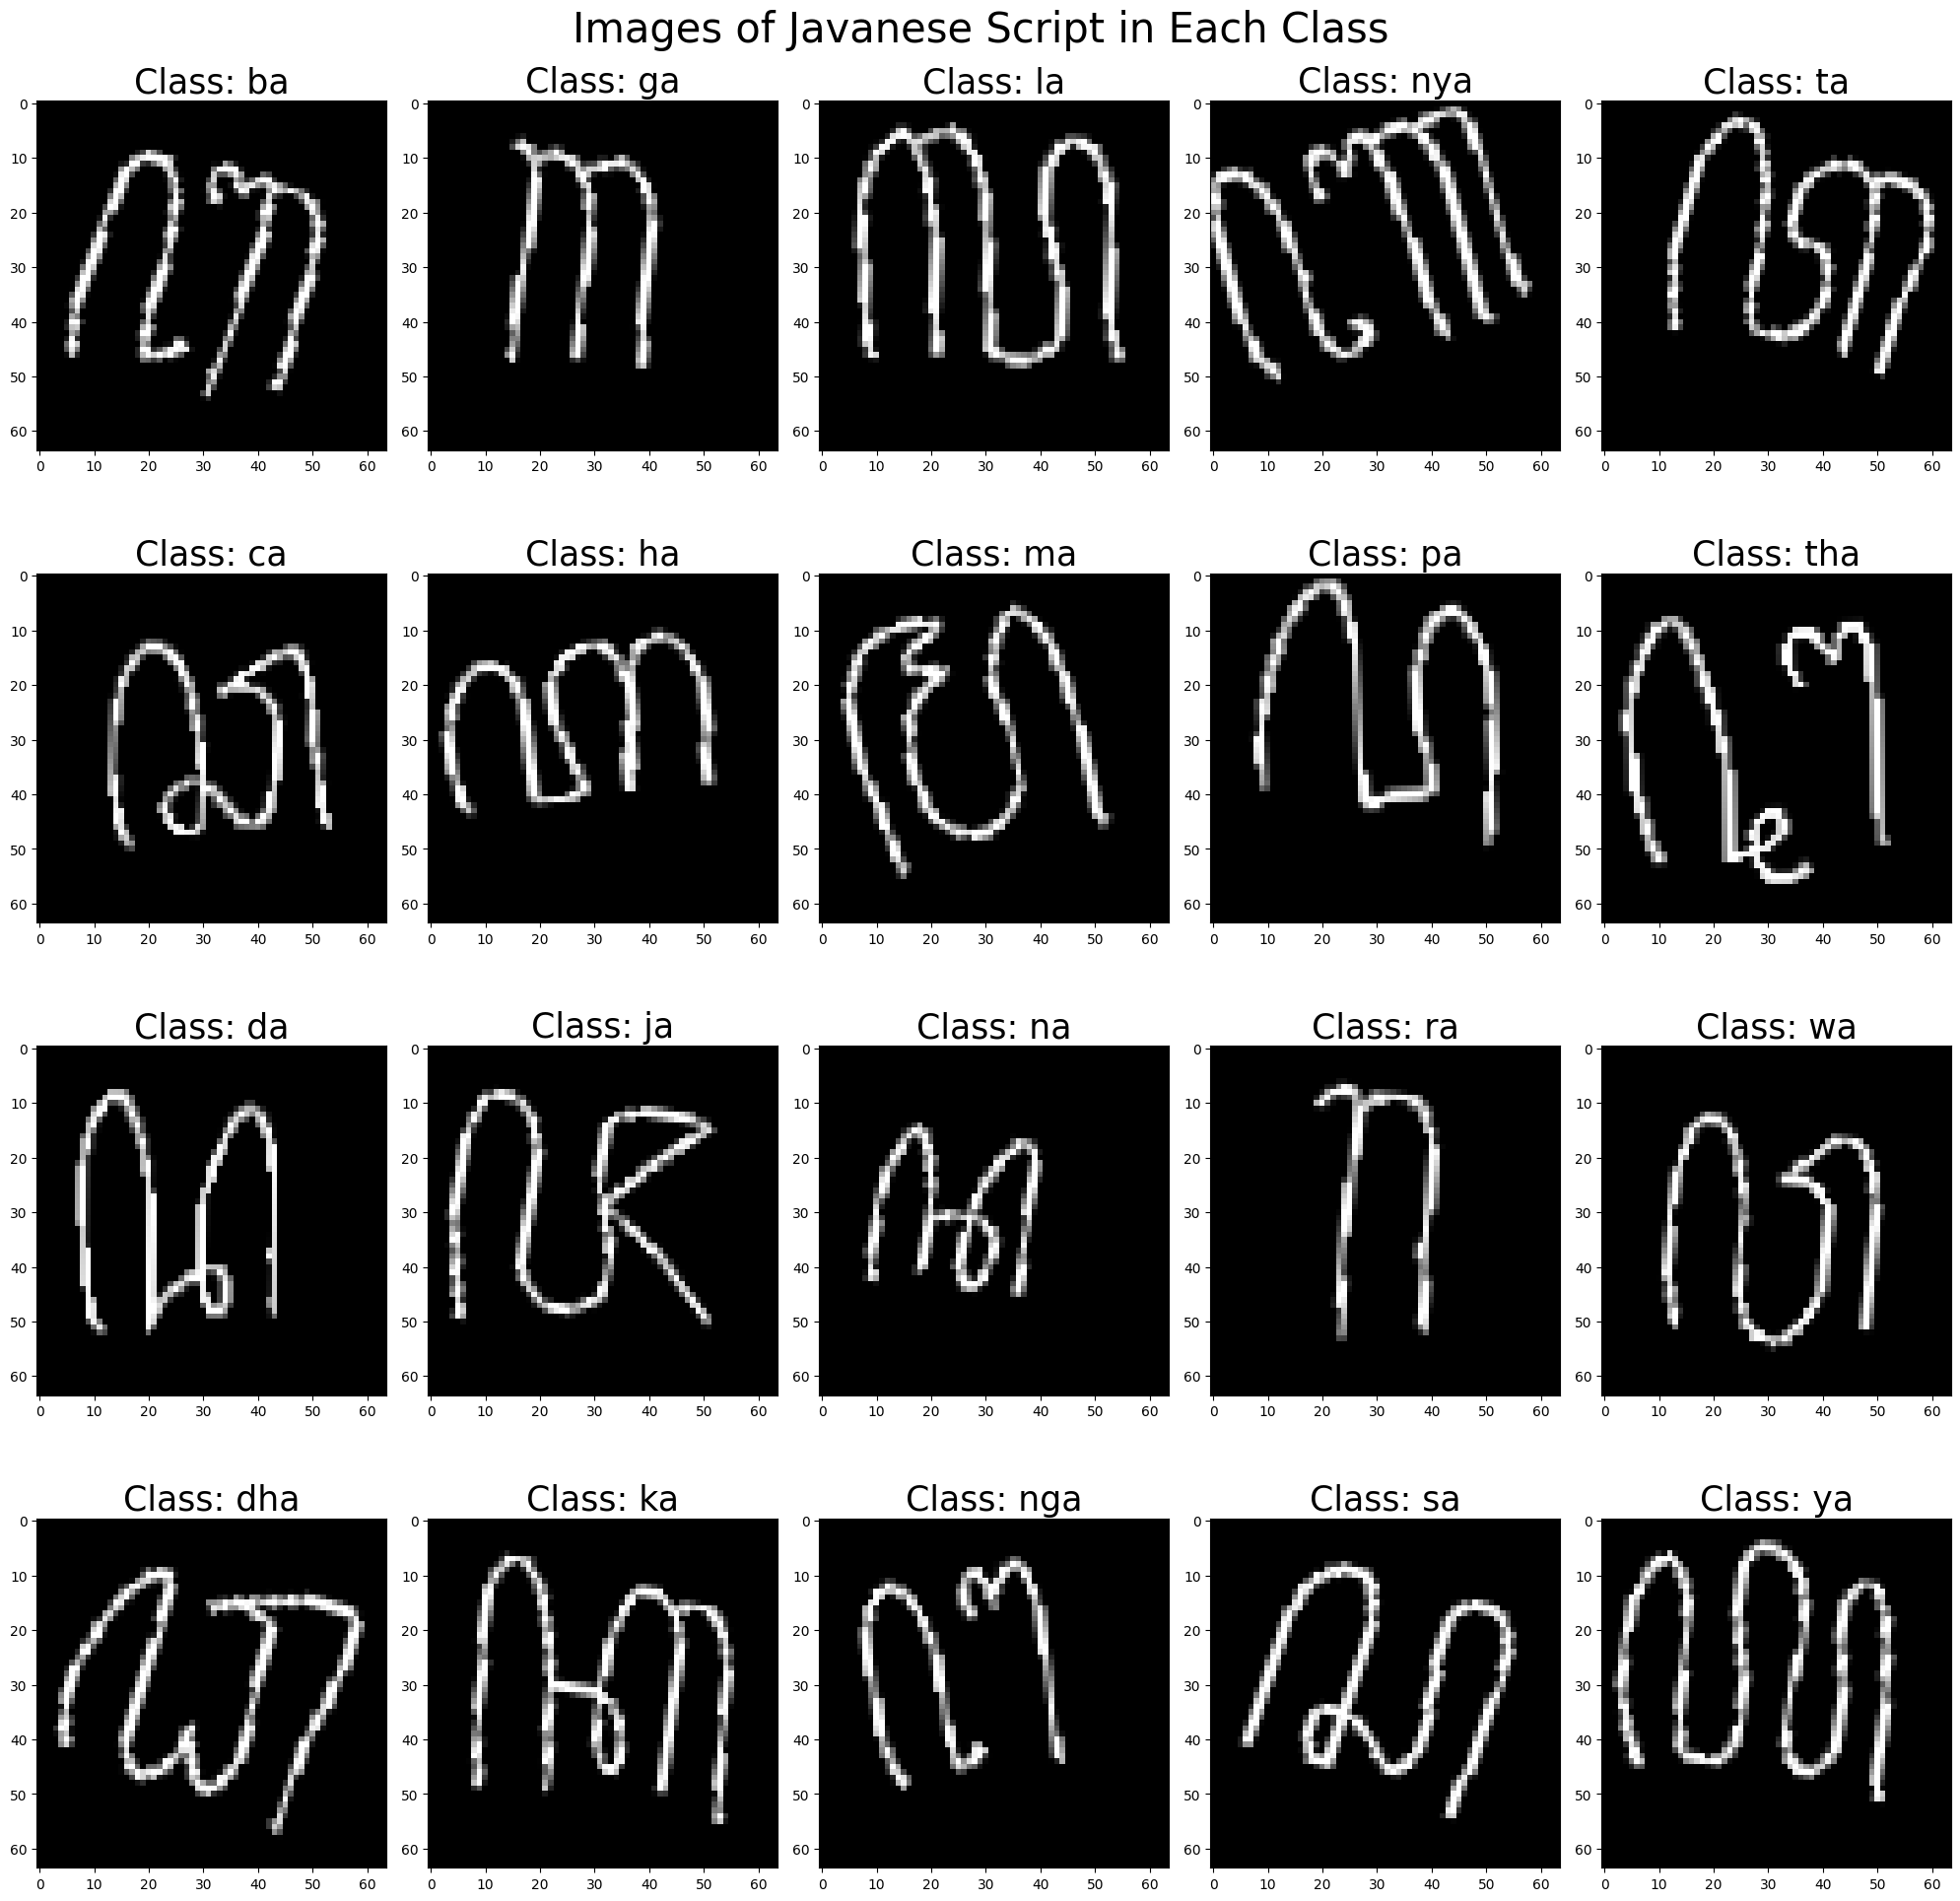

In [11]:
import cv2
import matplotlib.pyplot as plt
import random

class ImageProcessor:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path

    def display_random_image(self):
        # Inisialisasi plot
        fig, axes = plt.subplots(4, 5, figsize=(20, 20))

        # Iterasi melalui setiap subfolder
        for i, folder_name in enumerate(os.listdir(self.dataset_path)):
            folder_path = os.path.join(self.dataset_path, folder_name)

            # Pastikan yang diakses adalah subfolder
            if os.path.isdir(folder_path):

                # Mengambil satu gambar acak dari subfolder
                image_names = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
                random_image_name = random.choice(image_names)
                random_image_path = os.path.join(folder_path, random_image_name)

                # Membaca dan menampilkan gambar menggunakan Matplotlib
                random_image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)
                axes[i % 4, i // 4].imshow(random_image, cmap='gray')
                axes[i % 4, i // 4].set_title(f"Class: {folder_name}", fontsize=25)
                axes[i % 4, i // 4].axis('on')
                
        # Menambahkan Title Class Visualization 
        plt.suptitle("Images of Javanese Script in Each Class", fontsize=30)

        # Menampilkan plot
        plt.tight_layout()
        plt.show()

dataset_path = train_dir

# Inisialisasi objek ImageProcessor dan panggil metode display_random_image
processor = ImageProcessor(dataset_path)
processor.display_random_image()

In [12]:
def count_files(dir):
    arr = []
    for root, dirs, files in os.walk(dir):
        count = 0
        for name in files:
            if name.endswith(".png"):
              count = count + 1
        if count > 0:
          arr.append(count)
    return arr

def get_all_char_names(dir):
    arr = []
    for root, dirs, files in os.walk(dir):
        # print(dirs)
        arr.append(dirs)
        break
    return arr


20
[['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']]


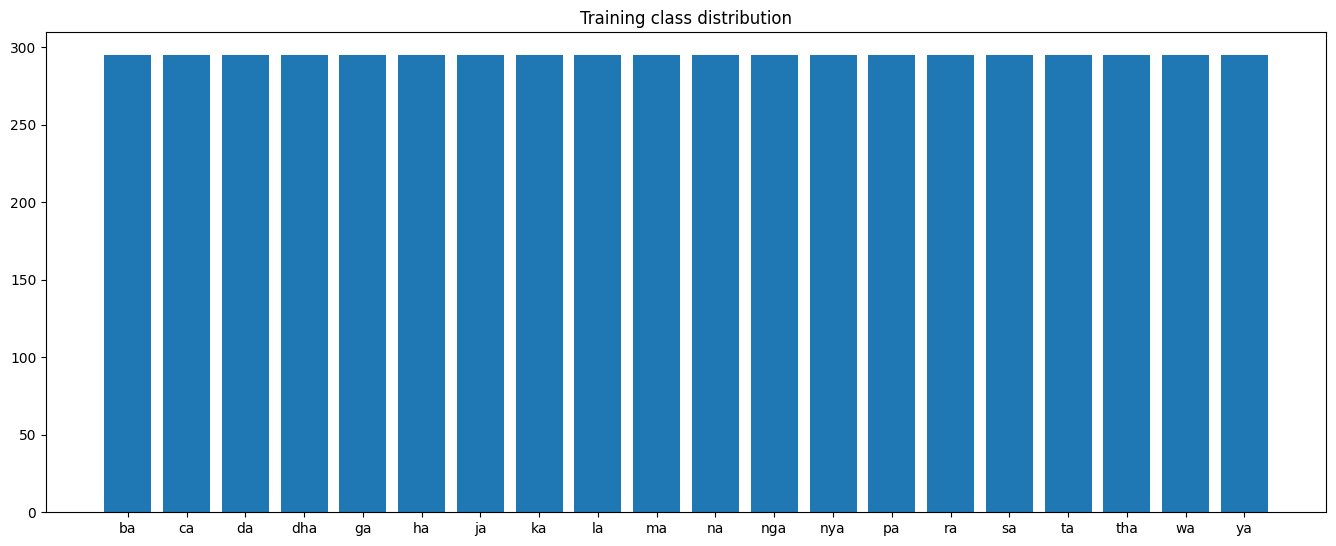

20
[['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']]


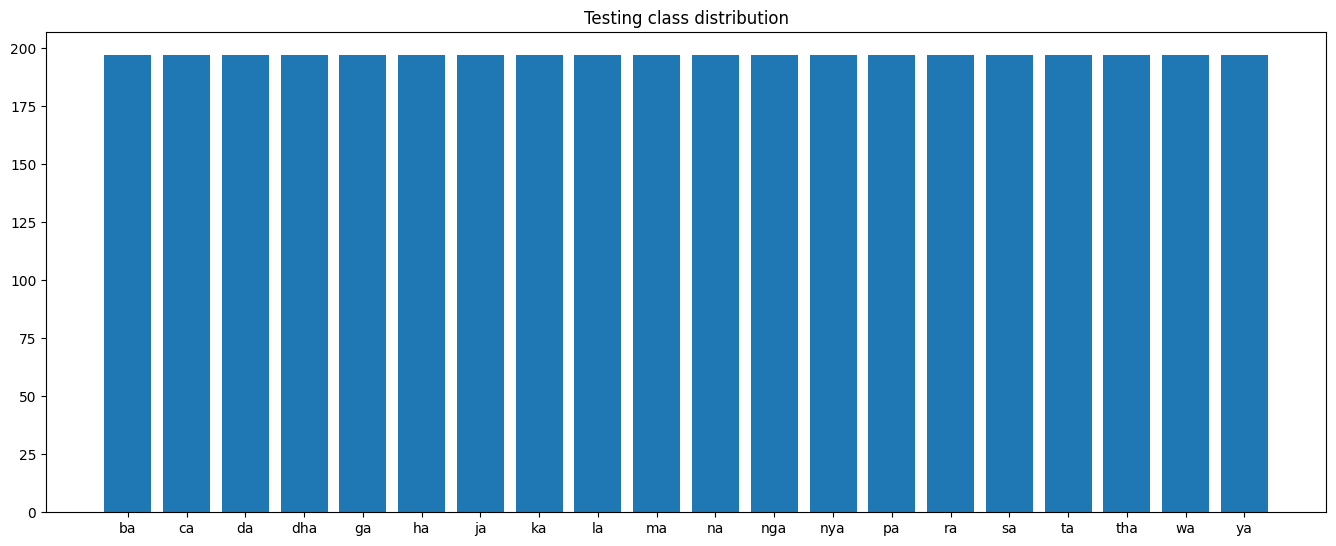

In [13]:
# Training Class
image_count = count_files(train_dir)
print(len(image_count))
chars = get_all_char_names(train_dir)
print(chars)

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(chars[0], image_count)
plt.title("Training class distribution")
plt.show()

# Testing Class
image_count = count_files(test_dir)
print(len(image_count))
chars = get_all_char_names(test_dir)
print(chars)

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(chars[0], image_count)
plt.title("Testing class distribution")
plt.show()

# Build the Model

### Image Data Generator

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Inisialisasi generator data untuk data pelatihan dan testing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    # classes=Class,
    batch_size=batch_size,
    target_size=image_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    # classes=Class,
    batch_size=batch_size,
    target_size=image_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 5900 images belonging to 20 classes.
Found 3940 images belonging to 20 classes.


In [15]:
from sklearn.utils.class_weight import compute_sample_weight

# Mencari class weights untuk mengatasi ketidakseimbangan kelas
class_weights = compute_sample_weight('balanced', train_generator.classes)
class_weight = dict(enumerate(class_weights))

### Model - CNN + VGG

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_vgg16(input_shape=(64, 64, 1), num_classes=num_classes):
    inputs = Input(shape=input_shape)

    # Blok 1
    conv1_1 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    batchnorm1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm1_1)
    batchnorm1_2 = BatchNormalization()(conv1_2)
    maxpool1 = MaxPooling2D((2, 2), strides=(2, 2))(batchnorm1_2)

    # Blok 2
    conv2_1 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(maxpool1)
    batchnorm2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm2_1)
    batchnorm2_2 = BatchNormalization()(conv2_2)
    maxpool2 = MaxPooling2D((2, 2), strides=(2, 2))(batchnorm2_2)

    # Blok 3
    conv3_1 = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(maxpool2)
    batchnorm3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm3_1)
    batchnorm3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm3_2)
    batchnorm3_3 = BatchNormalization()(conv3_3)
    maxpool3 = MaxPooling2D((2, 2), strides=(2, 2))(batchnorm3_3)

    # Blok 4
    conv4_1 = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(maxpool3)
    batchnorm4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm4_1)
    batchnorm4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm4_2)
    batchnorm4_3 = BatchNormalization()(conv4_3)
    maxpool4 = MaxPooling2D((2, 2), strides=(2, 2))(batchnorm4_3)

    # Blok 5
    conv5_1 = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(maxpool4)
    batchnorm5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm5_1)
    batchnorm5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(batchnorm5_2)
    batchnorm5_3 = BatchNormalization()(conv5_3)
    maxpool5 = MaxPooling2D((2, 2), strides=(2, 2))(batchnorm5_3)

    # Fully connected layers
    flatten = Flatten(name='flatten')(maxpool5)

    dense1 = Dense(256, activation='relu')(flatten)
    batchnorm_dense1 = BatchNormalization()(dense1)
    dropout1 = Dropout(0.75)(batchnorm_dense1)

    dense2 = Dense(128, activation='relu')(dropout1)
    batchnorm_dense2 = BatchNormalization()(dense2)
    dropout2 = Dropout(0.75)(batchnorm_dense2)

    outputs = Dense(num_classes, activation='softmax')(dropout2)

    model = Model(inputs=inputs, outputs=outputs)

    return model

# Create the VGG16 model
model = build_vgg16()

# Adam optimizer with learning rate scheduling, Weight Decay, and Gradient Clipping
opt = Adam(learning_rate=0.0001, weight_decay=1e-4, clipvalue=0.5)
    
# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,80

 Total params: 15,291,988 (58.33 MB)

 Trainable params: 15,282,772 (58.30 MB)

 Non-trainable params: 9,216 (36.00 KB)

In [17]:
# def build_vgg16(INPUT_SHAPE=(128, 128, 1), num_classes=num_classes):
#     model = Sequential()

#     # Blok 1
#     model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=INPUT_SHAPE))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2), strides=(2, 2)))

#     # Blok 2
#     model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2), strides=(2, 2)))

#     # Blok 3
#     model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2), strides=(2, 2)))

#     # Blok 4
#     model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2), strides=(2, 2)))

#     # Blok 5
#     model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
#     # Fully connected layers
#     model.add(Flatten(name='flatten'))

#     # lapisan Dense 1
#     model.add(Dense(256, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.75))

#     # lapisan Dense 2
#     model.add(Dense(128, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.75))

#     model.add(Dense(num_classes, activation='softmax'))

#     return model

# # Create the VGG16 model
# model = build_vgg16()

# # Adam optimizer with learning rate scheduling, Weight Decay, and Gradient Clipping
# opt = Adam(learning_rate=0.0001, weight_decay=1e-4, clipvalue=0.5)
    
# # Compile the model
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

### Training Model

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Fungsi untuk menetapkan learning rate secara dinamis
# def lr_scheduler(epoch, lr):
#     if epoch % 50 == 0 and epoch > 0:
#         lr = lr * 0.9  # Mengurangi learning rate setiap 50 epoch
#     return lr

# lr_schedule = LearningRateScheduler(lr_scheduler)

# Define the filepath where you want to save the model
checkpoint_filepath = "../save_models/aksarajawa_v0.3.keras"

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

callbacks_list = [checkpoint]

In [19]:
# # Menentukan jumlah langkah per epoch
# steps_per_epoch = train_generator.samples // batch_size 
# validation_steps = test_generator.samples // batch_size

# Melakukan pelatihan model
history = model.fit(train_generator,
                    batch_size=batch_size,
                    epochs=35,  
                    # callbacks=callbacks_list,  
                    validation_data=test_generator, 
                    # class_weight=class_weight
                    steps_per_epoch=None, #steps_per_epoch,
                    validation_steps=None) #validation_steps)

Epoch 1/35


c:\Users\wawn1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


185/185 ━━━━━━━━━━━━━━━━━━━━ 2335s 12s/step - accuracy: 0.1045 - loss: 4.4985 - val_accuracy: 0.0500 - val_loss: 3.5401
Epoch 2/35
185/185 ━━━━━━━━━━━━━━━━━━━━ 2258s 12s/step - accuracy: 0.4042 - loss: 2.0490 - val_accuracy: 0.0500 - val_loss: 5.0770
Epoch 3/35
185/185 ━━━━━━━━━━━━━━━━━━━━ 1924s 10s/step - accuracy: 0.5756 - loss: 1.3605 - val_accuracy: 0.1228 - val_loss: 3.4339
Epoch 4/35
185/185 ━━━━━━━━━━━━━━━━━━━━ 1109s 6s/step - accuracy: 0.7116 - loss: 0.9250 - val_accuracy: 0.9997 - val_loss: 0.0918
Epoch 5/35
185/185 ━━━━━━━━━━━━━━━━━━━━ 1099s 6s/step - accuracy: 0.7619 - loss: 0.7549 - val_accuracy: 1.0000 - val_loss: 0.0141
Epoch 6/35
185/185 ━━━━━━━━━━━━━━━━━━━━ 1107s 6s/step - accuracy: 0.8188 - loss: 0.5968 - val_accuracy: 1.0000 - val_loss: 0.0111
Epoch 7/35
185/185 ━━━━━━━━━━━━━━━━━━━━ 1100s 6s/step - accuracy: 0.8400 - loss: 0.5252 - val_accuracy: 1.0000 - val_loss: 0.0085
Epoch 8/35
185/185 ━━━━━━━━━━━━━━━━━━━━ 1101s 6s/step - accuracy: 0.8816 - loss: 0.4348 - val_accu

### Model Graph

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
# Menampilkan grafik training dan validation accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Try Predict

In [ ]:
from tensorflow.keras.models import load_model

# Saved Model
saved_model_path = checkpoint_filepath
model.save(saved_model_path)

# Memuat model dari file yang disimpan
loaded_model = load_model(saved_model_path)

# Evaluasi model menggunakan data uji
loss, accuracy = loaded_model.evaluate(test_generator)

# Print hasil evaluasi
print("Loss:", loss)
print("Accuracy:", accuracy)


In [ ]:
# Import the necessary modules
from sklearn import metrics
import math

test_steps_per_epoch = math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Hitung dan tampilkan classification report
report = metrics.classification_report(true_classes,
                                       predicted_classes,
                                       target_names = class_labels)
print(report)

In [ ]:
import pandas as pd
import seaborn as sn

# Buat DataFrame untuk confusion matrix
df_cm = pd.DataFrame(confusion_matrix,
                     index=[i for i in ("ba", "ca", "da", "dha", "ga", "ha", "ja", "ka", "la", "ma",
                                        "na", "nga", "nya", "pa", "ra", "sa", "ta", "tha", "wa", "ya")],

                     columns=[i for i in ("ba", "ca", "da", "dha", "ga", "ha", "ja", "ka", "la", "ma",
                                          "na", "nga", "nya", "pa", "ra", "sa", "ta", "tha", "wa", "ya")])
# Tampilkan heatmap
plt.figure(figsize=(15, 15))
sn.heatmap(df_cm, annot=True)

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np


# Make predictions
pred = model.predict(test_generator)

# Extract true labels from generator
true_labels = true_classes  

# One-hot encode true labels
true_labels_one_hot = label_binarize(true_labels, classes=np.arange(num_classes))

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_one_hot.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

colors = ['cornflowerblue', 'darkorange', 'forestgreen', 'red', 'purple', 'gray', 'black', 'pink',
          'cyan', 'magenta', 'yellow', 'orange', 'lime', 'blue', 'green', 'brown', 'indigo', 'violet', 'olive', 'teal']

# Plot the ROC curves for each class and the micro-average ROC curve
plt.figure(figsize=(8, 6))
lw = 2

plt.plot(fpr["micro"], tpr["micro"], lw=lw, label='micro-average ROC curve (AUC = {0:0.2f})'
                                                   ''.format(roc_auc["micro"]))

for i, color in zip(range(num_classes), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

# Try Test

In [ ]:
from keras.preprocessing import image
import numpy as np

# Muat model kembali dari variabel
loaded_model = load_model(saved_model_path)

# Load the grayscale image
# test_image_path1 = '../data/data_original/javaneseScript_byPhiard/prediction/ba17.png'
test_image_path1 = '../data/data_preprocessing/v0.3/data_split/test/ba/grayscale_ba116.pred3.b_aug_0_80.png'
img = image.load_img(test_image_path1, color_mode='grayscale', target_size=(128, 128))

# Convert the image to array
img_array = image.img_to_array(img)

# Expand the dimensions to match the input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# Perform the prediction
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())
predicted_class_name = class_labels[predicted_class_index]

# Print the result
print("Predicted class:", predicted_class_name)

In [ ]:
# # Muat model kembali dari variabel
# loaded_model = load_model(saved_model_path)

# # Menguji Model
# test_image_path1 = '../data/data_original/javaneseScript_byPhiard/prediction/ba17.png'
# img = image.load_img(test_image_path1, target_size=(64, 64))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path1)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# # predictions = loaded_model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path2 = '../data/databyPhiard_original/prediction/ba49.mine2.png'
# img = image.load_img(test_image_path2, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path2)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path3 = '../data/databyPhiard_original/prediction/ca2.png'
# img = image.load_img(test_image_path3, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path3)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path4 = '../data/databyPhiard_original/prediction/da5.png'
# img = image.load_img(test_image_path4, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path4)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path5 = '../data/databyPhiard_original/prediction/dha11.png'
# img = image.load_img(test_image_path5, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path5)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path6 = '../data/databyPhiard_original/prediction/ga16.png'
# img = image.load_img(test_image_path6, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path6)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path7 = '../data/databyPhiard_original/prediction/ha0.png'
# img = image.load_img(test_image_path7, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path7)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path8 = '../data/databyPhiard_original/prediction/ja12.png'
# img = image.load_img(test_image_path8, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path8)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path9 = '../data/databyPhiard_original/prediction/ka4.png'
# img = image.load_img(test_image_path9, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path9)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path10 = '../data/databyPhiard_original/prediction/la9.png'
# img = image.load_img(test_image_path10, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path10)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path11 = '../data/databyPhiard_original/prediction/ma.0.jpg'
# img = image.load_img(test_image_path11, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path11)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path12 = '../data/databyPhiard_original/prediction/ma.1.jpg'
# img = image.load_img(test_image_path12, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path12)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path13 = '../data/databyPhiard_original/prediction/ma15.png'
# img = image.load_img(test_image_path13, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path13)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path14 = '../data/databyPhiard_original/prediction/na1.png'
# img = image.load_img(test_image_path14, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path14)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path15 = '../data/databyPhiard_original/prediction/nga19.png'
# img = image.load_img(test_image_path15, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path15)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path16 = '../data/databyPhiard_original/prediction/nga220.pred.png'
# img = image.load_img(test_image_path16, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path16)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path17 = '../data/databyPhiard_original/prediction/nya14.png'
# img = image.load_img(test_image_path17, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path17)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path18 = '../data/databyPhiard_original/prediction/pa10.png'
# img = image.load_img(test_image_path18, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path18)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path19 = '../data/databyPhiard_original/prediction/ra164.pred.png'
# img = image.load_img(test_image_path19, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path19)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path20 = '../data/databyPhiard_original/prediction/ra3.png'
# img = image.load_img(test_image_path20, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path20)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path21 = '../data/databyPhiard_original/prediction/sa7.png'
# img = image.load_img(test_image_path21, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path21)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path22 = '../data/databyPhiard_original/prediction/ta6.png'
# img = image.load_img(test_image_path22, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path22)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path23 = '../data/databyPhiard_original/prediction/tha18.png'
# img = image.load_img(test_image_path23, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path23)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path24 = '../data/databyPhiard_original/prediction/wa8.png'
# img = image.load_img(test_image_path24, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path24)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path25 = '../data/databyPhiard_original/prediction/ya13.png'
# img = image.load_img(test_image_path25, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path25)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path26 = '../data/databyPhiard_original/prediction/nya_01.png'
# img = image.load_img(test_image_path26, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path26)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path26 = '../data/databyPhiard_original/prediction/sa_01.png'
# img = image.load_img(test_image_path26, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path26)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)

In [ ]:
# # Menguji Model
# test_image_path26 = '../data/databyPhiard_original/prediction/ha201.png'
# img = image.load_img(test_image_path26, target_size=(150, 150))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0

# img = imread(test_image_path26)
# plt.imshow(img)

# # Perform the prediction
# predictions = model.predict(img_array)
# predicted_class_index = np.argmax(predictions)
# class_labels = list(train_generator.class_indices.keys())
# predicted_class_name = class_labels[predicted_class_index]

# # Print the result
# print("Predicted class:", predicted_class_name)